# i3sense Import and process data for small samples of water uptake 0.02 x 0.02 x 0.03

In [62]:
import pandas as pd
import numpy as np
from typing import Dict, List, Tuple, Optional
import matplotlib.pyplot as plt
import plotly.express as px

## Data upload, table creation and getting moisture incerase from weight

In [63]:
# Read data
df = pd.read_excel("uptake_upraveno.xlsx", sheet_name=None)

#Create separate tables for lists
m_all   = df["hmotnosti"]
rh_all  = df["RH"]
temp_all = df["T"]

#Drop sensors A
rh_all = rh_all.drop (["sm 1 a","sm 2 a","bk 1 a","bk 2 a"], axis = 1)
temp_all = temp_all.drop (["t_sm 1 a","t_sm 2 a","t_bk 1 a","t_bk 2 a"], axis = 1)

# Convert time to seconds
tables = [m_all, rh_all, temp_all]

for table in tables:
    table["cas"] = pd.to_datetime(table["cas"], errors="coerce")
    table["time (s)"] = (table["cas"] - table["cas"].iloc[0]).dt.total_seconds()

# Compute relative masses (subtract first row)
m_rel = m_all.drop(columns=["cas", "time (s)"]) - m_all.drop(columns=["cas", "time (s)"]).iloc[0, :]

#print (m_all)
#print (m_rel)

w1_rel = m_rel/m_all.drop(columns=["cas", "time (s)"]).iloc[0,:]
w1_rel = pd.concat([m_all[["time (s)"]], w1_rel], axis=1)

#print (w1_rel)

## Separate values for beech and spruce, get densities rho

In [64]:
# pick only "bk" and "sm" columns
beech_cols  = [c for c in m_all.columns if c.startswith("bk")]
spruce_cols = [c for c in m_all.columns if c.startswith("sm")]

# densities at time zero (g/m³)
rho_spruce = m_all[spruce_cols].iloc[0] / (20 * 20 * 30)
rho_beech  = m_all[beech_cols].iloc[0]  / (20 * 20 * 30)

# convert to g/m³ → multiply by 1,000,000
rho_spruce *= 1_000_000
rho_beech  *= 1_000_000

print(rho_beech)
print(rho_spruce)

rho_spruce_mean = rho_spruce.mean ()
print(rho_spruce_mean)
rho_beech_mean = rho_beech.mean ()
print(rho_beech_mean)


# create new DataFrame with time + columns
w1_rel_spruce = w1_rel[["time (s)"] + spruce_cols]
w1_rel_beech = w1_rel[["time (s)"] + beech_cols]

m_all_spruce = m_all[["time (s)"] + spruce_cols]
m_all_beech = m_all[["time (s)"] + beech_cols]

bk 5    786.666667
bk 6    805.000000
bk 7    801.666667
bk 8    803.333333
Name: 0, dtype: float64
sm 1    510.000000
sm 2    539.166667
sm 3    578.333333
sm 4    580.000000
Name: 0, dtype: float64
551.875
799.1666666666666


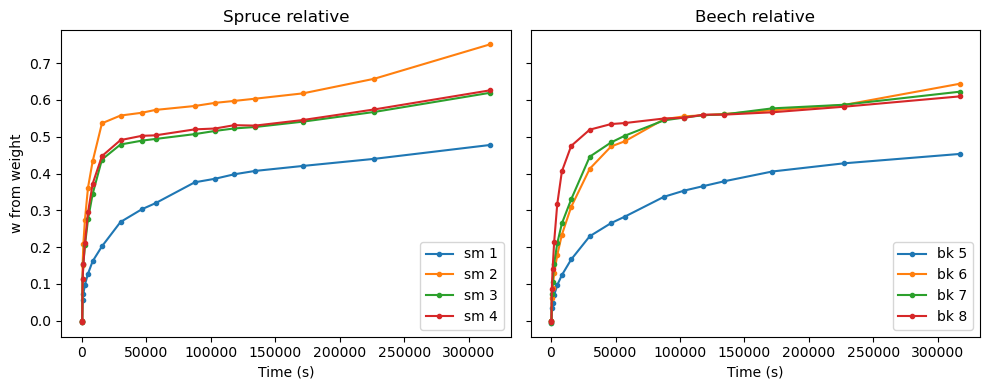

In [65]:
# plots of data
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

# --- SPRUCE ---
for col in w1_rel_spruce.columns:
    if col != "time (s)":
        axes[0].plot(
            w1_rel_spruce["time (s)"],
            w1_rel_spruce[col],
            marker=".",
            label=col
        )

axes[0].set_title("Spruce relative")
axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel("w from weight")
axes[0].legend()

# --- BEECH ---
for col in w1_rel_beech.columns:
    if col != "time (s)":
        axes[1].plot(
            w1_rel_beech["time (s)"],
            w1_rel_beech[col],
            marker=".",
            label=col
        )

axes[1].set_title("Beech relative")
axes[1].set_xlabel("Time (s)")
axes[1].legend()

plt.tight_layout()
plt.show()

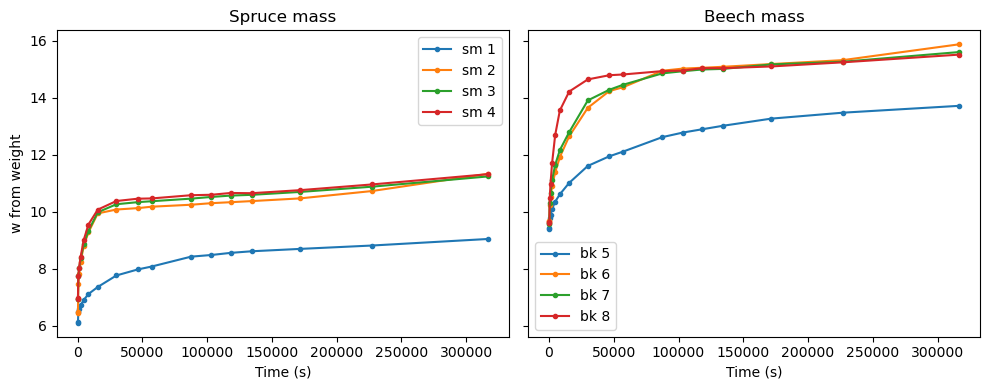

In [66]:
# plots of data
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

# --- SPRUCE ---
for col in m_all_spruce.columns:
    if col != "time (s)":
        axes[0].plot(
            m_all_spruce["time (s)"],
            m_all_spruce[col],
            marker=".",
            label=col
        )

axes[0].set_title("Spruce mass")
axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel("w from weight")
axes[0].legend()

# --- BEECH ---
for col in m_all_beech.columns:
    if col != "time (s)":
        axes[1].plot(
            m_all_beech["time (s)"],
            m_all_beech[col],
            marker=".",
            label=col
        )

axes[1].set_title("Beech mass")
axes[1].set_xlabel("Time (s)")
axes[1].legend()

plt.tight_layout()
plt.show()

In [67]:
df_beech = w1_rel_beech.copy ()
df_spruce = w1_rel_spruce.copy ()

moisture_cols_beech = df_beech.drop(columns=['time (s)']).columns
moisture_cols_spruce = df_spruce.drop(columns=['time (s)']).columns

# Calculate median and std across selected columns
beech_median = df_beech[moisture_cols_beech].median(axis=1)
beech_std    = df_beech[moisture_cols_beech].std(axis=1)

spruce_median = df_spruce[moisture_cols_spruce].median(axis=1)
spruce_std    = df_spruce[moisture_cols_spruce].std(axis=1)

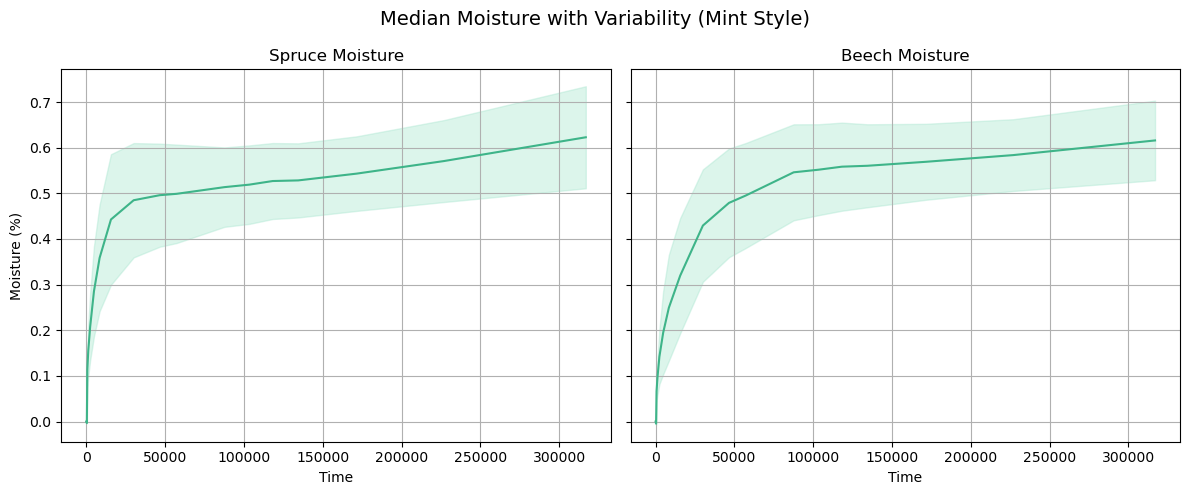

In [76]:
# Mint colors
mint_line_sp = '#3EB489'      # darker mint for lines
mint_fill_sp = '#A8E6CF'      # lighter mint for shaded area

# Plot with subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# --- SPRUCE (left) ---
axes[0].plot(df_spruce['time (s)'], spruce_median, label='Spruce Median', color=mint_line_sp)
axes[0].fill_between(df_spruce['time (s)'], spruce_median - spruce_std, spruce_median + spruce_std,
                     alpha=0.4, color=mint_fill_sp)
axes[0].set_title('Spruce Moisture')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Moisture (-)')
axes[0].grid(True)

# --- BEECH (right) ---
axes[1].plot(df_beech['time (s)'], beech_median, label='Beech Median', color=mint_line_sp)
axes[1].fill_between(df_beech['time (s)'], beech_median - beech_std, beech_median + beech_std,
                     alpha=0.4, color=mint_fill_sp)
axes[1].set_title('Beech Moisture')
axes[1].set_xlabel('Time')
axes[1].grid(True)

plt.suptitle('Median Moisture with Variability (Mint Style)', fontsize=14)
plt.tight_layout()
plt.show()

fig.savefig('small_com_med.png', dpi=300, bbox_inches="tight")

In [8]:
table_beech = pd.DataFrame({
    'time': df_beech['time (s)'],
    'median': beech_median,
    'std': beech_std
})

table_spruce = pd.DataFrame({
    'time': df_spruce['time (s)'],
    'median': spruce_median,
    'std': spruce_std
})

In [97]:
table_beech.to_csv ("w1_beech_comp_med.csv",index=False)
table_spruce.to_csv ("w1_spruce_comp_med.csv",index=False)

## COMSOL data

In [108]:
# Read the text file
df_spruce_valid = pd.read_csv(
    "spruce_valid.txt",     # path of the uploaded file
    sep=r"\s+",             # split by ANY whitespace
    skiprows=5,             # skip COMSOL header metadata
    header = None
    #names=["Time (s)", "c_b (1)", "c_b_first (1)"]  # rename columns
)
#df_spruce_valid

spruce_cm = pd.DataFrame ()
spruce_cm['Time (s)'] = df_spruce_valid.iloc[:, 0].copy() 
spruce_cm['w (-)'] = df_spruce_valid.iloc[:, 1].copy() 
spruce_cm['w_rel (-)'] = df_spruce_valid.iloc[:, 2].copy() 
spruce_cm

,Time (s),w (-),w_rel (-)
0,0.0,0.108056,0.000000
1,1584.3,0.262281,0.154225
2,3168.6,0.322599,0.214543
3,4752.9,0.365767,0.257711
4,6337.2,0.399892,0.291837
...,...,...,...
196,310522.8,0.655310,0.547254
197,312107.1,0.655310,0.547254
198,313691.4,0.655310,0.547254
199,315275.7,0.655310,0.547254


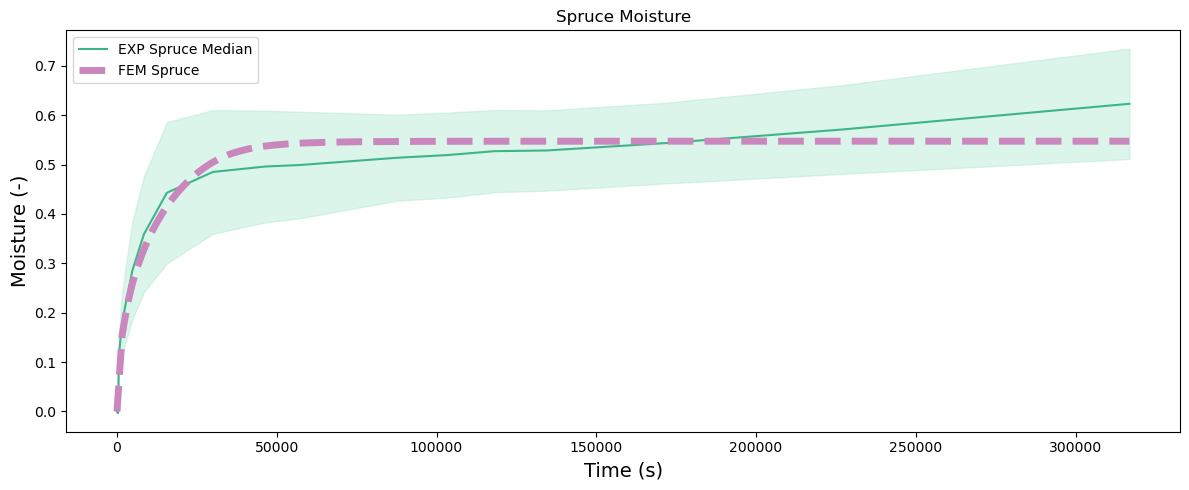

In [110]:
## Plot figure

# Mint colors
mint_line_sp = '#3EB489'      # EXP lines
mint_fill_sp = '#A8E6CF'      # EXP shaded area
pink_line_sp = '#C987BD'      # FEM

fig, ax = plt.subplots(figsize=(12, 5))  # only ONE axis, not axes[0]

# --- EXPERIMENTAL SPUCE ---
ax.plot(df_spruce['time (s)'], spruce_median, label='EXP Spruce Median', color=mint_line_sp)
ax.fill_between(df_spruce['time (s)'], spruce_median - spruce_std, spruce_median + spruce_std,
                alpha=0.4, color=mint_fill_sp)

# --- FEM SPRUCE (from uploaded file) ---
ax.plot(spruce_cm['Time (s)'], spruce_cm['w_rel (-)'], label='FEM Spruce', linestyle='--',color=pink_line_sp, linewidth = 5)

# Labels
ax.set_title('Spruce Moisture')
ax.set_xlabel('Time (s)',fontsize=14)
ax.set_ylabel('Moisture (-)',fontsize=14)
ax.grid(False)
ax.legend()

plt.tight_layout()
plt.show()
fig.savefig('spruce_valid_comp.png', dpi=300, bbox_inches="tight")

# ANSYS data

In [ ]:
ansys = {}

In [59]:
df_a = pd.read_csv(
    "time__vs__avg_mc4.txt", header = None,)
df_a

,0,1,2
0,33.333333,20.445771,10.445771
1,66.666667,21.038426,11.038426
2,100.000000,21.604984,11.604984
3,133.333333,22.129241,12.129241
4,166.666667,22.614886,12.614886
...,...,...,...
1495,49866.666700,68.890769,58.890769
1496,49900.000000,68.890191,58.890191
1497,49933.333300,68.889421,58.889421
1498,49966.666700,68.888413,58.888413


In [60]:
mc = 'mc4'


ansys[mc] = pd.DataFrame()
ansys[mc]['time (s)'] = df_a[0].copy()
ansys[mc]['w (%)'] = df_a[1].copy()
ansys [mc]['w_rel (%)'] = df_a[2].copy()
ansys [mc]['w_rel (-)']=ansys [mc]['w_rel (%)'] .div(100)

ansys

{'mc3':      time (s)      w (%)  w_rel (%)  w_rel (-)
 0         100  21.520836  11.520836   0.115208
 1         200  22.913461  12.913461   0.129135
 2         300  24.141662  14.141662   0.141417
 3         400  25.219172  15.219172   0.152192
 4         500  26.184680  16.184680   0.161847
 ..        ...        ...        ...        ...
 995     99600  68.916750  58.916750   0.589167
 996     99700  68.916750  58.916750   0.589168
 997     99800  68.916751  58.916751   0.589168
 998     99900  68.916751  58.916751   0.589168
 999    100000  68.916752  58.916751   0.589168
 
 [1000 rows x 4 columns],
 'mc4':           time (s)      w (%)  w_rel (%)  w_rel (-)
 0        33.333333  20.445771  10.445771   0.104458
 1        66.666667  21.038426  11.038426   0.110384
 2       100.000000  21.604984  11.604984   0.116050
 3       133.333333  22.129241  12.129241   0.121292
 4       166.666667  22.614886  12.614886   0.126149
 ...            ...        ...        ...        ...
 1495  4986

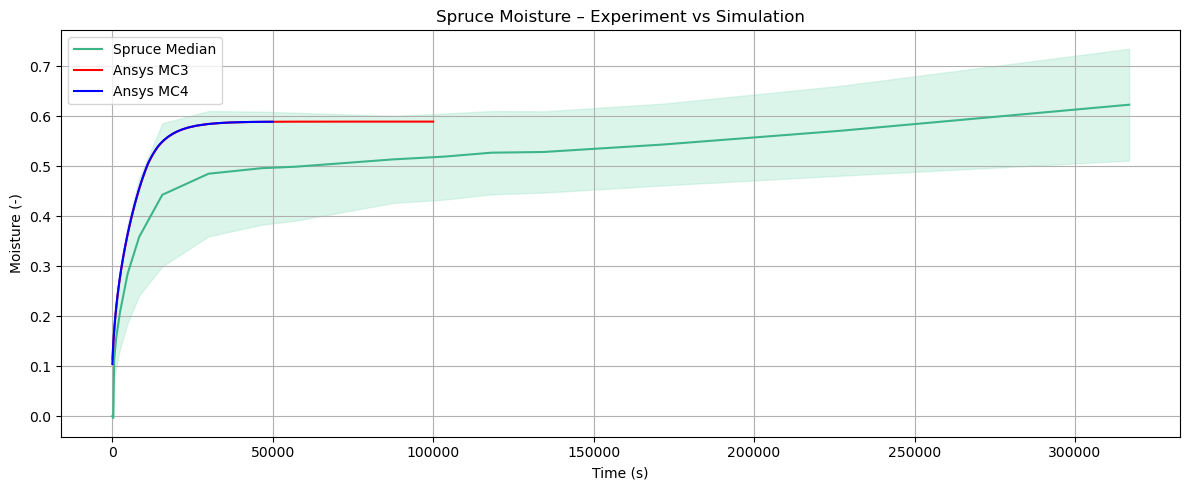

In [61]:
fig, ax = plt.subplots(figsize=(12, 5))

# Experimental SPRUCE
ax.plot(df_spruce['time (s)'], spruce_median, label='Spruce Median', color=mint_line)
ax.fill_between(df_spruce['time (s)'], spruce_median - spruce_std, spruce_median + spruce_std,
                 alpha=0.4, color=mint_fill)

# ANSYS SPRUCE (MC1)
#ax.plot(ansys['mc1']['time (s)'], ansys['mc1']['w_rel (-)'], label='Ansys MC1', color='red')
ax.plot(ansys['mc3']['time (s)'], ansys['mc3']['w_rel (-)'], label='Ansys MC3', color='red')
ax.plot(ansys['mc4']['time (s)'], ansys['mc4']['w_rel (-)'], label='Ansys MC4', color='blue')

# Labels & Format
ax.set_title('Spruce Moisture – Experiment vs Simulation')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Moisture (-)')
ax.grid(True)
ax.legend()

plt.tight_layout()
plt.show()

## Moisture content w2 from RH

In [9]:
A = {}
B = {}

temp_cols = [c for c in temp_all.columns if c.startswith("t_")] 
rh_drop = rh_all.drop (["cas","time (s)"], axis = 1)
rh_cols = [c for c in rh_drop.columns]

w2 = rh_all[["time (s)"]].copy()


for T_col, rh_col in zip(temp_cols, rh_cols):
    Tk = temp_all[T_col] + 273.15

    A[T_col] = 7.731706 - 0.014348 * Tk
    B[T_col] = 0.008746 + 0.000567 * Tk

    RH = rh_drop[rh_col] / 100.0

    w2[f"{rh_col}"] = (1 / B[T_col]) * np.log(
        A[T_col] / np.log(1 / RH)
    ) / 100.0

beech_cols  = [c for c in w2.columns if "bk" in c]
spruce_cols = [c for c in w2.columns if "sm" in c]

w2_spruce = w2[["time (s)"] + spruce_cols].copy()
w2_beech = w2[["time (s)"] + beech_cols].copy()

#w2.head(40)    # first 20 rows

w2_rel_spruce = w2_spruce - w2_spruce.iloc[0,:]
w2_rel_beech = w2_beech- w2_beech.iloc[0,:]

## Plot w2_rel

In [11]:
rh_all

,cas,sm 1 c,sm 1 b,sm 2 c,sm 2 b,ambient,bk 1 c,bk 1 b,bk 2 c,bk 2 b,time (s)
0,2025-10-18 19:14:06,44.24,43.85,46.50,46.16,50.59,47.68,52.17,46.60,52.59,0.0
1,2025-10-18 19:15:06,44.20,43.88,46.46,46.19,50.64,47.67,52.17,46.60,52.51,60.0
2,2025-10-18 19:16:18,44.11,43.85,46.50,46.11,50.67,47.75,52.20,46.56,52.56,132.0
3,2025-10-18 19:17:18,44.17,43.89,46.51,46.17,50.76,47.65,52.17,46.53,52.45,192.0
4,2025-10-18 19:20:39,44.26,44.31,46.43,46.13,54.46,47.70,52.18,46.52,52.53,393.0
...,...,...,...,...,...,...,...,...,...,...,...
2962,2025-10-23 06:57:46,95.24,94.11,95.78,93.23,42.26,93.01,97.79,96.21,92.74,387820.0
2963,2025-10-23 07:02:46,95.29,94.09,95.75,93.18,42.21,93.03,97.82,96.19,92.81,388120.0
2964,2025-10-23 07:07:46,95.19,94.10,95.69,93.22,42.27,93.08,97.81,96.21,92.83,388420.0
2965,2025-10-23 07:12:46,95.26,94.12,95.73,93.19,41.77,93.06,97.83,96.24,92.76,388720.0


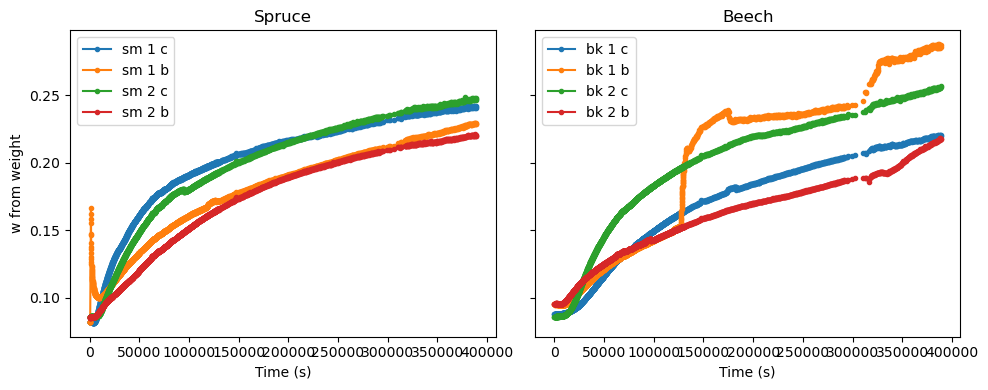

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

# --- SPRUCE ---
for col in w2_spruce.columns:
    if col != "time (s)":
        axes[0].plot(
            w2_spruce["time (s)"],
            w2_spruce[col],
            marker=".",
            label=col
        )

axes[0].set_title("Spruce")
axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel("w from weight")
axes[0].legend()

# --- BEECH ---
for col in w2_beech.columns:
    if col != "time (s)":
        axes[1].plot(
            w2_beech["time (s)"],
            w2_beech[col],
            marker=".",
            label=col
        )

axes[1].set_title("Beech")
axes[1].set_xlabel("Time (s)")
axes[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
w2_ambient = w2[["time (s)", "ambient"]].copy()
w2_ambient

w2_ambient.plot (x="time (s)")

In [ ]:
w2["ambient_interp"] = w2["ambient"].interpolate(
    method="linear",
    limit_direction="both"
)

plt.plot(w2["time (s)"], w2["ambient"], alpha=0.4, label="original",linewidth = 6)
plt.plot(w2["time (s)"], w2["ambient_interp"], label="interp")
plt.legend()
plt.show()

w2

In [ ]:
from scipy.signal import savgol_filter

w2["ambient_smooth"] = savgol_filter(
    w2["ambient_interp"],
    window_length=101,
    polyorder=3
)

fig = px.line(
    w2,
    x="time (s)",
    y=["ambient", "ambient_smooth"],
    title="Ambient smoothing"
)
fig.show()

In [ ]:
#from scipy.signal import medfilt

#ambient_med = medfilt(w2["ambient_interp"], kernel_size=7)
#w2["ambient_smooth"] = savgol_filter(ambient_med, 101, 3)

#fig = px.line(
#    w2,
#    x="time (s)",
#    y=["ambient", "ambient_smooth"],
#    title="Ambient smoothing"
#)
#fig.show()

In [ ]:
## Ambient from constant values
T_const = 20+273.15
RH_const = 50

A_const = 7.731706 - 0.014348 * T_const
B_const = 0.008746 + 0.000567 * T_const

RH_cons = rh_drop[rh_col] / 100.0

w_const = (1 / B_const) * np.log(
        A_const / np.log(1 / (RH_const/100))
    ) / 100.0

w_const

In [ ]:
# dry density
k_av = 0.5
rho_0_spruce_mean = rho_spruce_mean*(1+k_av*w_const)/(1+w_const)
rho_0_spruce_mean

## Export values

In [ ]:
w1_rel_spruce.to_csv ("w1_spruce_comp.csv",index=False)
w1_rel_beech.to_csv ("w1_beech_comp.csv",index=False)
w2_rel_spruce.to_csv ("w2_spruce_comp.csv",index=False)
w2_rel_beech.to_csv ("w2_beech_comp.csv",index=False)
#w2_ambient.to_csv ("w_ambient_comp.csv",index=False)